In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install networkx matplotlib numpy


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

NUM_AGENTS = 50
MEMORY_CAPACITY = 10
MAX_STEPS = 100000
CONSENSUS_THRESHOLD = 0.9
NUM_RUNS = 5


In [5]:
class Agent:
    def __init__(self, agent_id):
        self.id = agent_id
        self.memory = []
    
    def create_new_name(self, global_name_counter):
        name = f"Name_{global_name_counter}"
        return name
    
    def add_name(self, name):
        if name not in self.memory:
            if len(self.memory) >= MEMORY_CAPACITY:
                self.memory.pop(0)
            self.memory.append(name)
    
    def choose_name(self):
        if not self.memory:
            return None
        return random.choice(self.memory)


In [22]:
def create_fully_connected_network(num_nodes):
    return nx.complete_graph(num_nodes)

def create_ring_network(num_nodes):
    G = nx.Graph()
    nodes = list(range(num_nodes))
    for i in nodes:
        G.add_edge(i, (i + 1) % num_nodes)  # Connect to next node
        G.add_edge(i, (i - 1) % num_nodes)  # Connect to previous node
    return G

def add_random_connections(G, num_random_edges):
    nodes = list(G.nodes())
    added_edges = 0
    while added_edges < num_random_edges:
        u, v = random.sample(nodes, 2)
        while u == v or G.has_edge(u, v):
            u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
            added_edges += 1
    return G

def simulate_naming_game(graph):
    agents = {node: Agent(node) for node in graph.nodes()}
    global_name_counter = 0
    step = 0
    consensus_reached = False
    total_agents = len(agents)

    # Data for visualization
    steps_list = []
    total_memory_sizes = []
    agents_with_most_common_name = []
    num_unique_names_list = []

    while step < MAX_STEPS and not consensus_reached:
        speaker = random.choice(list(graph.nodes()))
        neighbors = list(graph.neighbors(speaker))
        
        if speaker in neighbors:
            neighbors.remove(speaker)
        
        if not neighbors:
            continue  

        speaker_agent = agents[speaker]

        spoken_name = speaker_agent.choose_name()
        if spoken_name is None:
            spoken_name = speaker_agent.create_new_name(global_name_counter)
            global_name_counter += 1
            speaker_agent.add_name(spoken_name)

        for hearer in neighbors:
            hearer_agent = agents[hearer]

            if spoken_name in hearer_agent.memory:
                speaker_agent.memory = [spoken_name]
                hearer_agent.memory = [spoken_name]
            else:
                hearer_agent.add_name(spoken_name)

        step += 1
        total_memory_size = sum(len(agent.memory) for agent in agents.values())

        steps_list.append(step)
        total_memory_sizes.append(total_memory_size)

        first_memory_names = [agent.memory[0] if agent.memory else None for agent in agents.values()]
        name_counts = {}
        for name in first_memory_names:
            if name is not None:
                name_counts[name] = name_counts.get(name, 0) + 1

        num_unique_names = len(name_counts)
        num_unique_names_list.append(num_unique_names)

        if name_counts:
            most_common_name = max(name_counts, key=name_counts.get)
            most_common_name_count = name_counts[most_common_name]
            agents_with_most_common_name.append(most_common_name_count)
        else:
            most_common_name_count = 0
            agents_with_most_common_name.append(0)

        # Check for consensus
        if most_common_name_count >= CONSENSUS_THRESHOLD * total_agents:
            consensus_reached = True

    return {
        'steps_taken': step,
        'steps_list': steps_list,
        'total_memory_sizes': total_memory_sizes,
        'agents_with_most_common_name': agents_with_most_common_name,
        'num_unique_names_list': num_unique_names_list
    }




In [23]:
def plot_steps_to_consensus(results, network_type):
    steps_list = [result['steps_taken'] for result in results[network_type]]
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, NUM_RUNS + 1), steps_list, color='skyblue')
    plt.xlabel('Run Number')
    plt.ylabel('Number of Steps to Reach Consensus')
    plt.title(f'{network_type.replace("_", " ").title()} Network: Steps to Reach Consensus over {NUM_RUNS} Runs')
    plt.ylim(0, max(steps_list) * 1.1)
    plt.xticks(range(1, NUM_RUNS + 1))
    plt.grid(axis='y')
    plt.show()

def plot_convergence(results, network_type):
    plt.figure(figsize=(10, 6))
    for idx, result in enumerate(results[network_type]):
        plt.plot(result['steps_list'], result['num_unique_names_list'], label=f'Run {idx + 1}')
    plt.xlabel('Number of Steps')
    plt.ylabel('Number of Unique Names in Network')
    plt.title(f'{network_type.replace("_", " ").title()} Network: Convergence Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


results = {
    'fully_connected': [],
    'ring': [],
    'ring_random': []
}

for run in range(NUM_RUNS):
    G = create_fully_connected_network(NUM_AGENTS)
    simulation_data = simulate_naming_game(G)
    results['fully_connected'].append(simulation_data)
    print(f"Run {run + 1} on Fully Connected Network completed in {simulation_data['steps_taken']} steps.")

for run in range(NUM_RUNS):
    G = create_ring_network(NUM_AGENTS)
    simulation_data = simulate_naming_game(G)
    results['ring'].append(simulation_data)
    print(f"Run {run + 1} on Ring Network completed in {simulation_data['steps_taken']} steps.")

for run in range(NUM_RUNS):
    G = create_ring_network(NUM_AGENTS)
    G = add_random_connections(G, num_random_edges=10)
    simulation_data = simulate_naming_game(G)
    results['ring_random'].append(simulation_data)
    print(f"Run {run + 1} on Ring Network with Random Connections completed in {simulation_data['steps_taken']} steps.")

Run 1 on Fully Connected Network completed in 1 steps.
Run 2 on Fully Connected Network completed in 1 steps.
Run 3 on Fully Connected Network completed in 1 steps.
Run 4 on Fully Connected Network completed in 1 steps.
Run 5 on Fully Connected Network completed in 1 steps.
Run 1 on Ring Network completed in 5282 steps.
Run 2 on Ring Network completed in 12396 steps.
Run 3 on Ring Network completed in 16426 steps.
Run 4 on Ring Network completed in 12491 steps.
Run 5 on Ring Network completed in 10427 steps.
Run 1 on Ring Network with Random Connections completed in 4911 steps.
Run 2 on Ring Network with Random Connections completed in 2651 steps.
Run 3 on Ring Network with Random Connections completed in 1894 steps.
Run 4 on Ring Network with Random Connections completed in 3056 steps.
Run 5 on Ring Network with Random Connections completed in 2009 steps.


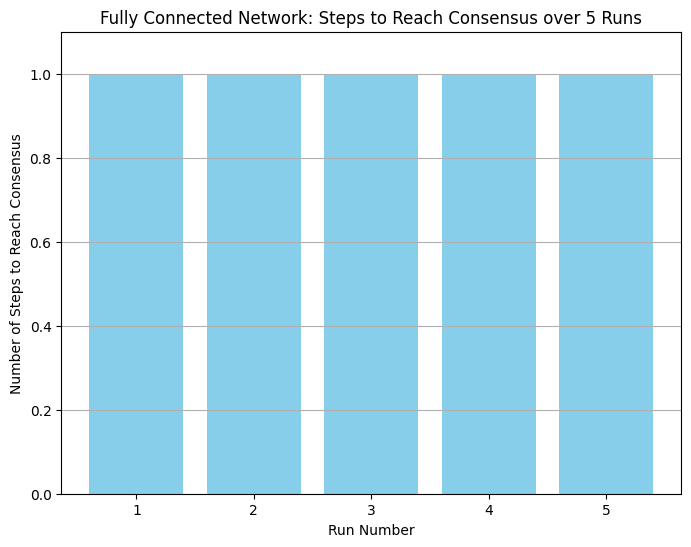

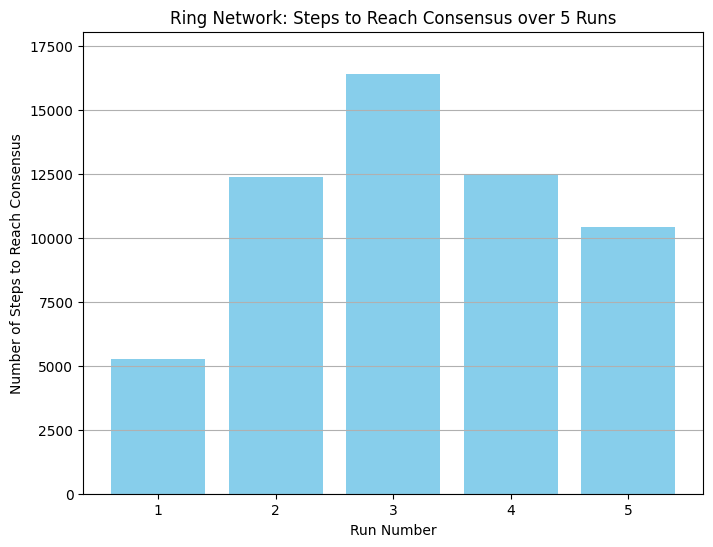

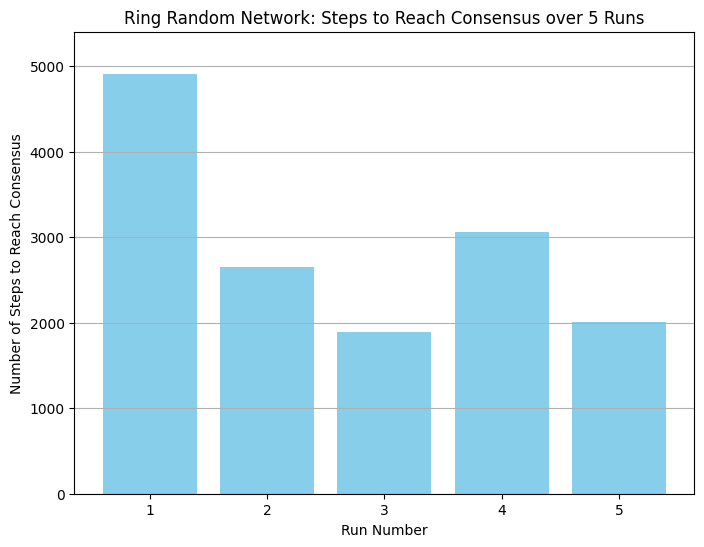

In [24]:
plot_steps_to_consensus(results, 'fully_connected')
plot_steps_to_consensus(results, 'ring')
plot_steps_to_consensus(results, 'ring_random')

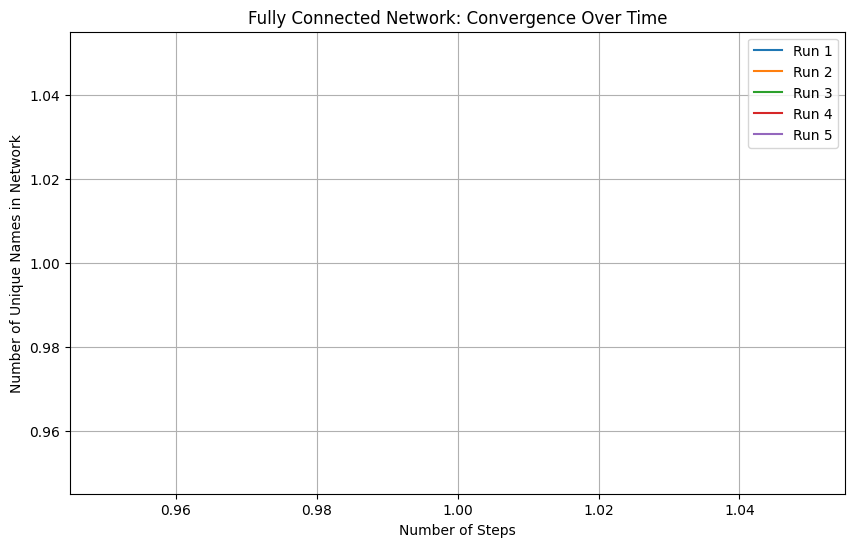

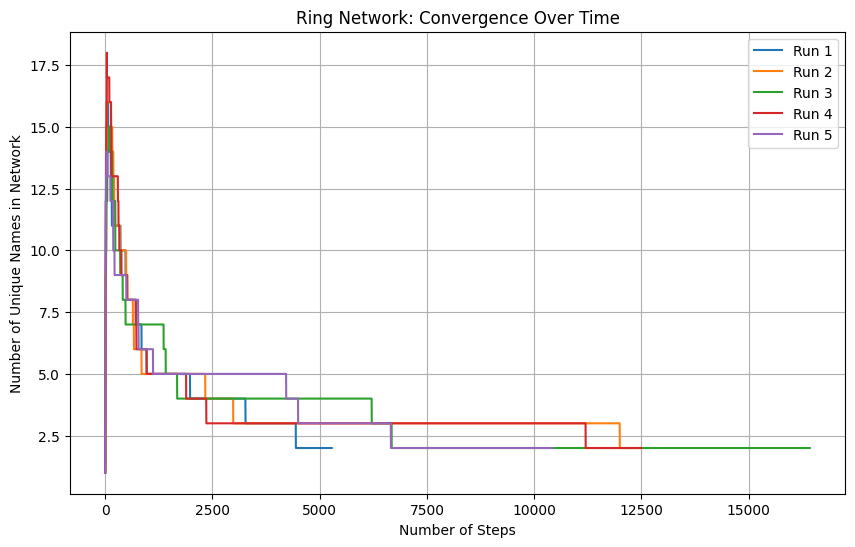

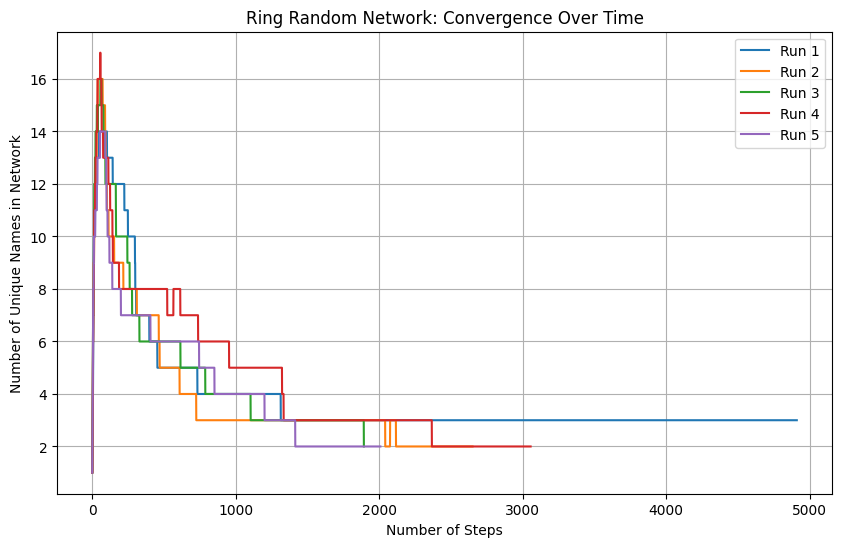

In [25]:
plot_convergence(results, 'fully_connected')
plot_convergence(results, 'ring')
plot_convergence(results, 'ring_random')

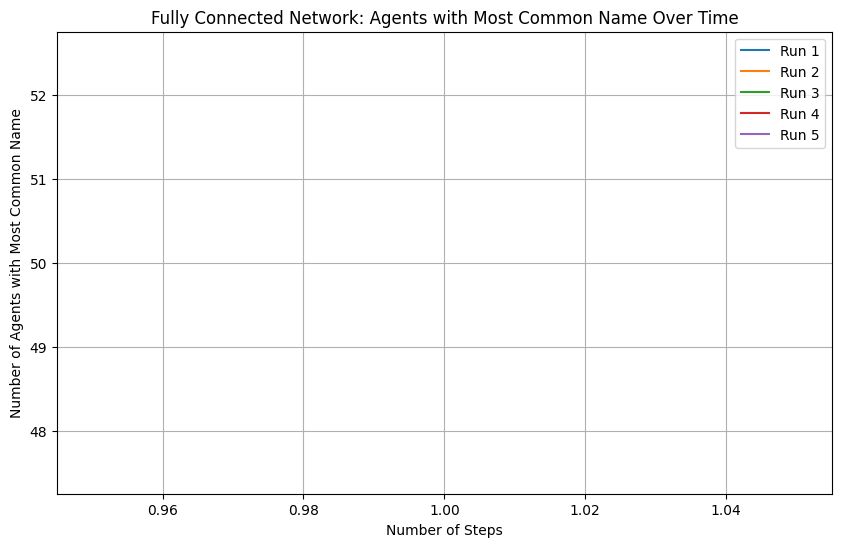

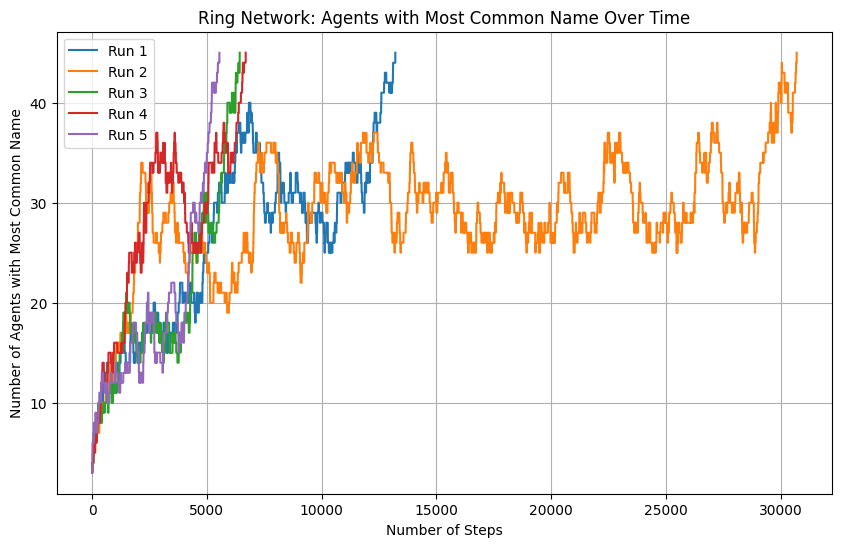

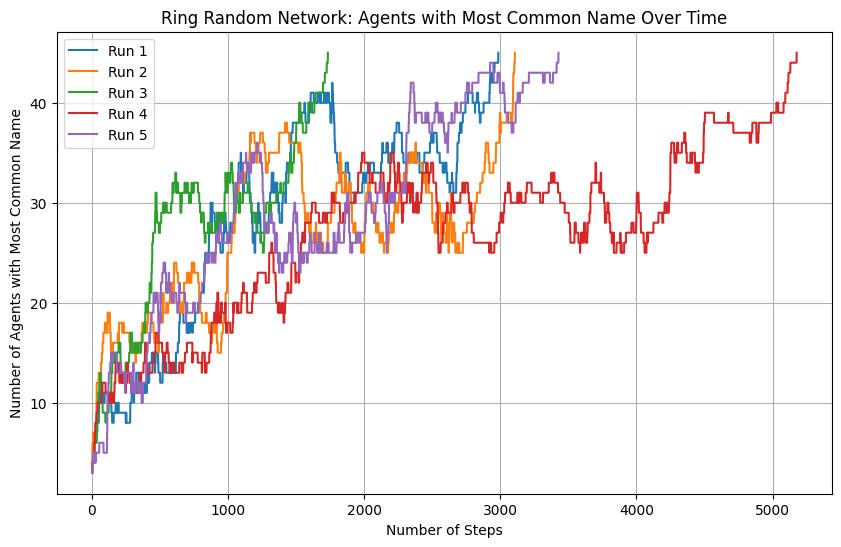

In [20]:
def plot_agents_with_common_name_over_time(results, network_type):
    plt.figure(figsize=(10, 6))
    for idx, result in enumerate(results[network_type]):
        plt.plot(result['steps_list'], result['agents_with_most_common_name'], label=f'Run {idx + 1}')
    plt.xlabel('Number of Steps')
    plt.ylabel('Number of Agents with Most Common Name')
    plt.title(f'{network_type.replace("_", " ").title()} Network: Agents with Most Common Name Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_agents_with_common_name_over_time(results, 'fully_connected')
plot_agents_with_common_name_over_time(results, 'ring')
plot_agents_with_common_name_over_time(results, 'ring_random')


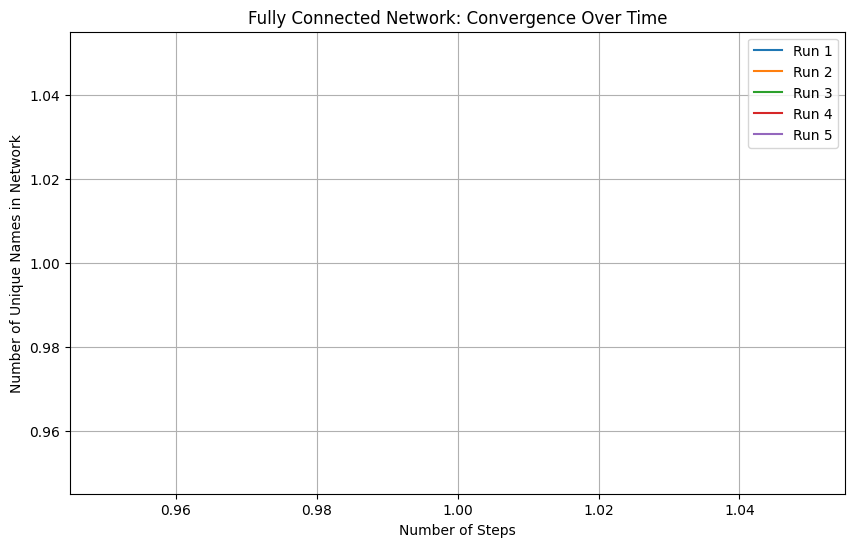

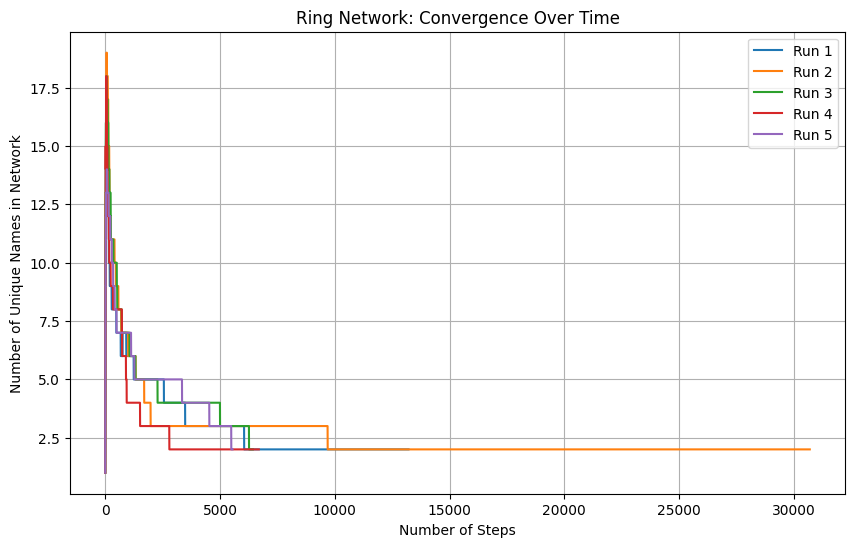

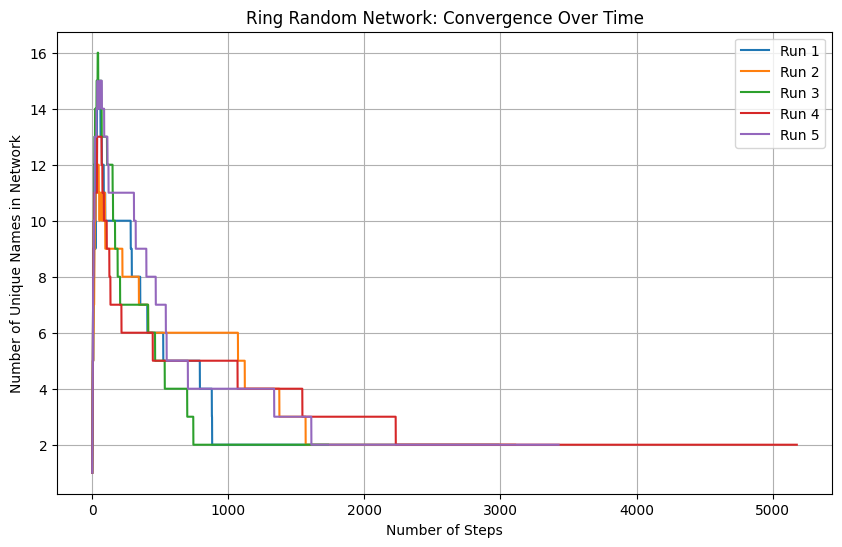

In [21]:
def plot_convergence(results, network_type):
    plt.figure(figsize=(10, 6))
    for idx, result in enumerate(results[network_type]):
        plt.plot(result['steps_list'], result['num_unique_names_list'], label=f'Run {idx + 1}')
    plt.xlabel('Number of Steps')
    plt.ylabel('Number of Unique Names in Network')
    plt.title(f'{network_type.replace("_", " ").title()} Network: Convergence Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ biểu đồ cho Mạng Hoàn Toàn Kết Nối
plot_convergence(results, 'fully_connected')

# Vẽ biểu đồ cho Mạng Vòng
plot_convergence(results, 'ring')

# Vẽ biểu đồ cho Mạng Vòng với Kết Nối Ngẫu Nhiên
plot_convergence(results, 'ring_random')